Monitoramento e Fairness

In [28]:
import pandas as pd 
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

Carregar modelo e vetor já treinados

In [29]:
modelo_path = '../model.joblib'
vetor_path = '../vectorizer.joblib'
dados_path = '../data/news_limpo.csv'

if not (os.path.exists(modelo_path) and os.path.exists(vetor_path)):
    raise FileExistsError('Treine e salve o modelo antes de executar!')

model = joblib.load(modelo_path)
vectorizer = joblib.load(vetor_path)
df = pd.read_csv(dados_path)
display(df.head())

,title,text,subject,date,label,text_length
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON () - The head of a conservative Rep...,politicsNews,"December 31, 2017",real,4652
1,U.S. military to accept transgender recruits o...,WASHINGTON () - Transgender people will be all...,politicsNews,"December 29, 2017",real,4070
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON () - The special counsel investigat...,politicsNews,"December 31, 2017",real,2782
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON () - Trump campaign adviser George ...,politicsNews,"December 30, 2017",real,2447
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON () - President Donald Trump...,politicsNews,"December 29, 2017",real,5197


Monitoramento

In [30]:
novos_textos = ["Breaking news: New advancements in AI technology are transforming industries.",
                 "Exclusive report: Major breakthrough in renewable energy.",
                 "Update: New study reveals the impact of social media on mental health.",
                 "Breaking news: New study uncovers the effects of climate change on wildlife.",
                 "Exclusive report: Investigation into the rise of deepfake technology.",
                 # Fake
                 "Ovnis are real and have been visiting Earth for decades.",
                 "Aliens built the pyramids.",
                 "Bigfoot is hiding in the woods.",
                 "The Loch Ness Monster is real.",
                 "Mermaids have been spotted off the coast."
]

novos_df = pd.DataFrame({'title': novos_textos})
display(novos_df)

,title
0,Breaking news: New advancements in AI technolo...
1,Exclusive report: Major breakthrough in renewa...
2,Update: New study reveals the impact of social...
3,Breaking news: New study uncovers the effects ...
4,Exclusive report: Investigation into the rise ...
5,Ovnis are real and have been visiting Earth fo...
6,Aliens built the pyramids.
7,Bigfoot is hiding in the woods.
8,The Loch Ness Monster is real.
9,Mermaids have been spotted off the coast.


Vetorizar e predição

In [31]:
novos_vetores = vectorizer.transform(novos_df['title'])
novos_preds = model.predict(novos_vetores)
novos_df['label_predito'] = novos_preds
print(novos_df)

                                               title label_predito
0  Breaking news: New advancements in AI technolo...          fake
1  Exclusive report: Major breakthrough in renewa...          real
2  Update: New study reveals the impact of social...          fake
3  Breaking news: New study uncovers the effects ...          fake
4  Exclusive report: Investigation into the rise ...          real
5  Ovnis are real and have been visiting Earth fo...          fake
6                         Aliens built the pyramids.          fake
7                    Bigfoot is hiding in the woods.          fake
8                     The Loch Ness Monster is real.          fake
9          Mermaids have been spotted off the coast.          real


Porcentagem de cada classe

In [32]:
class_dist = novos_df['label_predito'].value_counts(normalize=True)
print('Distribuição dos rótulos preditos nos novos dados:')
print(class_dist)

Distribuição dos rótulos preditos nos novos dados:
label_predito
fake    0.7
real    0.3
Name: proportion, dtype: float64


Fairness - Vieses

In [33]:
df['title_len'] = df['title'].apply(len)
df['len_category'] = pd.cut(df['title_len'], bins=[0,50,150,10000], labels=['curto', 'medio', 'longo'])
display(df['len_category'])


0        medio
1        medio
2        medio
3        medio
4        medio
         ...  
44893    medio
44894    medio
44895    medio
44896    medio
44897    medio
Name: len_category, Length: 44898, dtype: category
Categories (3, object): ['curto' < 'medio' < 'longo']

Predições conjunto de validação

In [34]:
vetores = vectorizer.transform(df['title'])
df['pred'] = model.predict(vetores)
display(df['pred'])

0        real
1        real
2        fake
3        real
4        real
         ... 
44893    fake
44894    fake
44895    real
44896    fake
44897    real
Name: pred, Length: 44898, dtype: object

Avaliação de acurácia

In [35]:
for cat in df['len_category'].unique():
    subset = df[df['len_category'] == cat]
    if not subset.empty:
        acuracia = (subset['label'] == subset['pred']).mean()
        print(f'Acurácia para os textos {cat}: {acuracia:.2f} (N={len(subset)})')

Acurácia para os textos medio: 0.96 (N=42164)
Acurácia para os textos curto: 0.93 (N=1717)
Acurácia para os textos longo: 0.99 (N=1017)


Desafio fairness


Matriz de confusão para textos medio:
[[20906  1009]
 [  661 19588]]


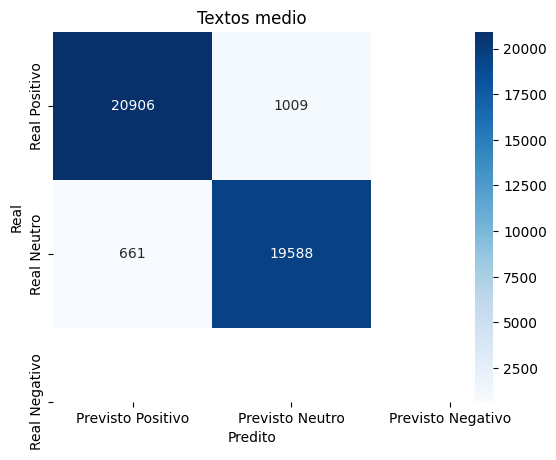


Matriz de confusão para textos curto:
[[ 483   66]
 [  62 1106]]


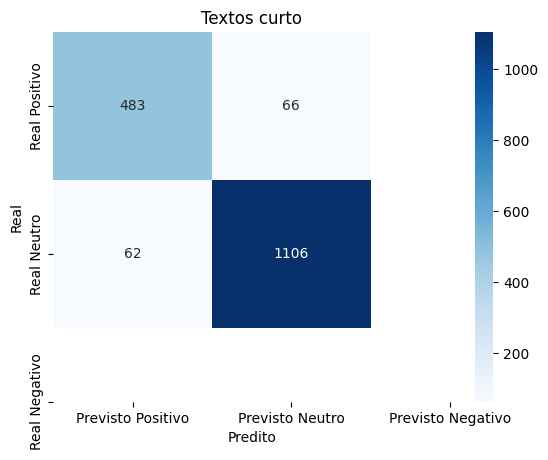


Matriz de confusão para textos longo:
[[1005   12]
 [   0    0]]


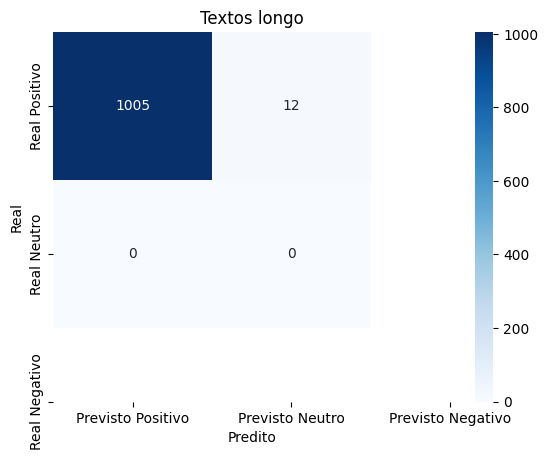

In [36]:
for cat in df['len_category'].unique():
    subset = df[df['len_category'] == cat]
    if not subset.empty:
        print(f'\nMatriz de confusão para textos {cat}:')
        print(confusion_matrix(subset['label'], subset["pred"]))
        sns.heatmap(confusion_matrix(subset['label'], subset["pred"]),
                    annot=True, fmt='d', cmap='Blues',
                     xticklabels=["Previsto Positivo", "Previsto Neutro", "Previsto Negativo"],
                    yticklabels=["Real Positivo", "Real Neutro", "Real Negativo"])
        plt.title(f'Textos {cat}')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.show()